In [0]:
from google.colab import auth
auth.authenticate_user()
project_id = 'euphoric-oath-172818'
!gcloud config set project {project_id}

Updated property [core/project].


# requirements.txt

In [0]:
%%writefile requirements.txt
google-cloud-storage==1.16.1
pandas==0.25.3
numpy==1.17.4
scikit-image==0.15.0
https://download.pytorch.org/whl/cpu/torch-1.3.1%2Bcpu-cp37-cp37m-linux_x86_64.whl
torchvision==0.4.2

Writing requirements.txt


# main.py

In [0]:
from google.cloud import storage
import pandas as pd
import numpy as np
from skimage import io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torchvision.transforms as transforms
import torch.nn.functional as F

In [0]:
net = None
PROJECT_ID = 'euphoric-oath-172818'
BUCKET_NAME = 'test_tensorflow_010148'
MODEL_FILE = 'network.pt'
IMG_FILE = '30010.jpg'
CLASSES = ['Action', 'Adventure', 'Comedy', 
           'Drama', 'Fantasy', 'Kids',
           'Music', 'School', 'Sci-Fi', 
           'Slice of Life']

In [0]:
net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features # Input # of neurons of last FC layer
net.fc = nn.Linear(num_ftrs, 10) # Output # of neurons of last FC layer
        
def show_classes(label, classes = CLASSES):
  return [class_ for i, class_ in zip(label, classes) if i == 1]

def images_to_probs(net, images):
    output = net(images)
    probs = [[1/(1+np.exp(-xx)) for xx in x.detach().cpu().numpy()] for x in output]
    preds_as_list = [[1 if xx >= 0.5 else 0 for xx in x] for x in probs]
    return probs, preds_as_list

def download_blob(bucket_name, source_blob_name, destination_file_name):
  """Downloads a blob from the bucket."""
  storage_client = storage.Client(project = PROJECT_ID)
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(source_blob_name)
  blob.download_to_filename(destination_file_name)

def handler(request):
    request_json = request.get_json(silent=True)
    request_args = request.args

    if request_json and 'name' in request_json:
        IMG_FILE = request_json['name']
    elif request_args and 'name' in request_args:
        IMG_FILE = request_args['name']
    else:
        return 'No Img File Found'
  
    global net
    if net is None:
        download_blob(BUCKET_NAME, MODEL_FILE,'/tmp/' + MODEL_FILE)
        net.load_state_dict(torch.load('/tmp/' + MODEL_FILE))
        net.eval()

    IMG_FILE_NAME = IMG_FILE.split('/')[-1]
    download_blob(BUCKET_NAME, IMG_FILE, '/tmp/' + IMG_FILE_NAME)
    image_raw = io.imread('/tmp/' + IMG_FILE_NAME)
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])
    images = transform(image_raw).unsqueeze(0)
    probs, preds_as_list = images_to_probs(net, images)
    preds_as_class = [show_classes(x) for x in preds_as_list]
    return str(probs) + '\n' + str(preds_as_class)


# Run some tests

In [0]:
import requests
from google.colab import drive
drive.mount('/content/drive')
CLOUD_FUNCTION_URL = 'https://us-central1-euphoric-oath-172818.cloudfunctions.net/test_pytorch'
result = requests.post(CLOUD_FUNCTION_URL, json={'name':'figures/30010.jpg'})

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [0]:
r = eval(result.text.replace('\n',', '))
d = pd.DataFrame({'class': CLASSES, 'prob':r[0][0]}).sort_values(by = 'prob', ascending = False)
d['label'] = ['p>=0.5' if x >= 0.5 else 'p<0.5' for x in d['prob']]
d

,class,prob,label
9,Slice of Life,0.678361,p>=0.5
4,Fantasy,0.669486,p>=0.5
2,Comedy,0.609186,p>=0.5
6,Music,0.553809,p>=0.5
1,Adventure,0.524759,p>=0.5
7,School,0.519694,p>=0.5
0,Action,0.388942,p<0.5
8,Sci-Fi,0.372375,p<0.5
3,Drama,0.264667,p<0.5
5,Kids,0.247880,p<0.5


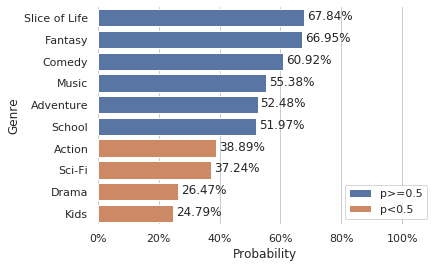

In [0]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 4))
sns.set_color_codes("pastel")
p = sns.barplot(x='prob', y='class', data=d, hue='label',dodge=False)
ax.set(xlim=(0, 1.1), 
       ylabel="Genre",
       xlabel="Probability")
ax.legend( loc="lower right", frameon=True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
for pp in p.patches:
  p.annotate(format(pp.get_width(), '.2%'), 
             (pp.get_width() + 0.01,
             pp.get_y() + pp.get_height() +0),
             ha = 'left', 
             va = 'center', 
             xytext = (0, 10), 
             textcoords = 'offset points')

sns.despine(left=True, bottom=True)
p = p.get_figure()
p.savefig('/content/drive/My Drive/pytorch_project/test.jpg', bbox_inches='tight')